In [149]:
from pickletools import uint8

import numpy as np
import cv2
import matplotlib.pyplot as plt
import math

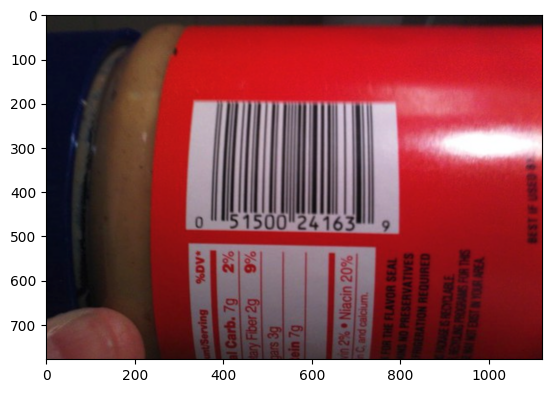

In [150]:
# Load the image and convert it to grayscale.
# a = cv2.imread('resources/barcode/barcode114.png')
a = cv2.imread('resources/barcode/barcode10.png')
img = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
plt.imshow(img)

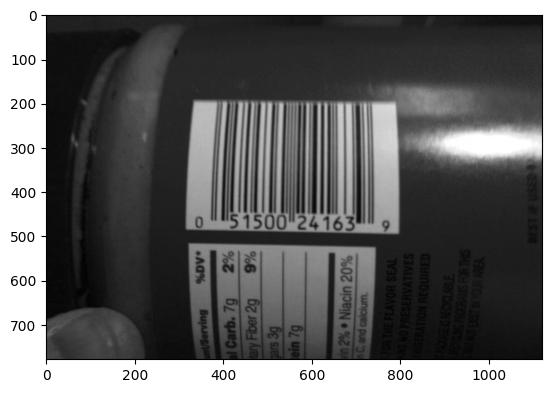

In [151]:
# Convert the image into grey for processing.
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap='gray')

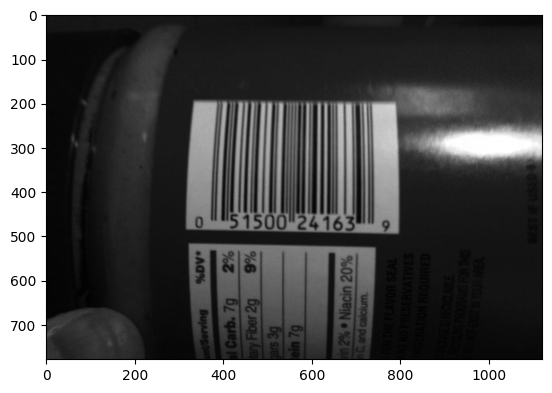

In [152]:
# Increase contrast
def adjust_gamma(image, gamma=1.0):
    # build a lookup table mapping the pixel values [0, 255] to
    # their adjusted gamma values
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
                      for i in np.arange(0, 256)]).astype("uint8")
    # apply gamma correction using the lookup table
    return cv2.LUT(image, table)


gamma_corrected = adjust_gamma(gray, 0.8)
plt.imshow(gamma_corrected, cmap='gray')

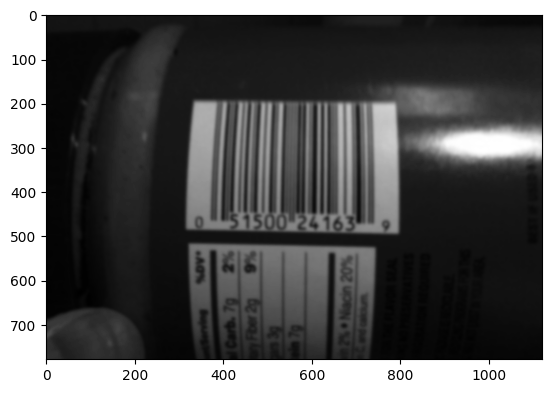

In [153]:
# Remove noise
def gaussian_blur(image, ksize):
    return cv2.GaussianBlur(image, ksize, 0)


blurred = gaussian_blur(gamma_corrected, (15, 15))
plt.imshow(blurred, cmap='gray')

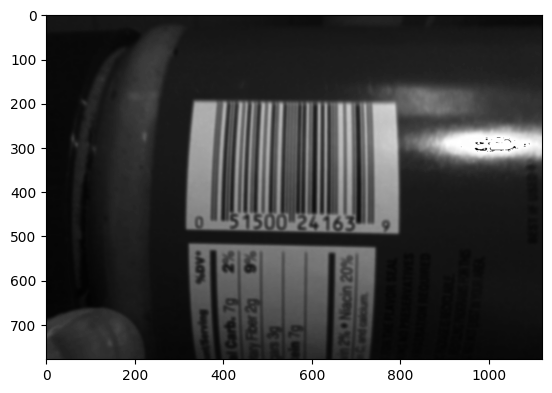

In [154]:
# Detect edges (canny no good here!)
def high_boost_filter(image, ksize):
    mean = np.ones(ksize, np.float32) / math.prod(ksize)
    blur = cv2.filter2D(image, -1, mean)
    # edges = image - blur
    # Subtract the y-gradient from the x-gradient
    edges1 = cv2.subtract(image, blur)
    edges1 = cv2.convertScaleAbs(edges1)

    return image + edges1


boosted = high_boost_filter(blurred, (9, 9))
plt.imshow(boosted, cmap='gray')

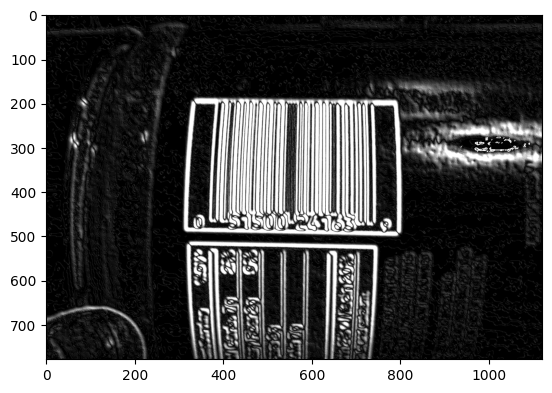

In [155]:
def detect_gradient(image):
    # Find vertical line intensity change (using x-axis, when y = 0).
    grad_x = cv2.Sobel(image, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=-1)

    # Find horizontal line intensity change(using y-axis, when x = 0).
    grad_y = cv2.Sobel(image, ddepth=cv2.CV_32F, dx=0, dy=1, ksize=-1)

    # Subtract the y-gradient from the x-gradient
    grad = cv2.subtract(grad_x, grad_y)

    # Converts negative values to absolute values |x|.
    return cv2.convertScaleAbs(grad)


gradient = detect_gradient(boosted)
plt.imshow(gradient, cmap='gray')

In [156]:
# Blur and threshold the image.
def blur_threshold(image, ksize):
    blurred = cv2.blur(image, ksize=ksize)
    (_, thresh) = cv2.threshold(blurred, 225, 255, cv2.THRESH_BINARY)
    return thresh


thresh = blur_threshold(gradient, [3, 3])

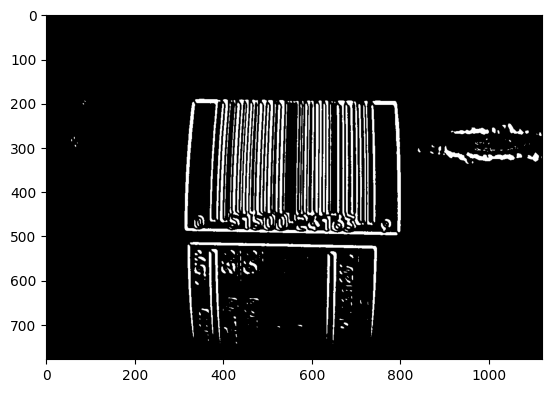

In [157]:
plt.imshow(thresh, cmap='gray')

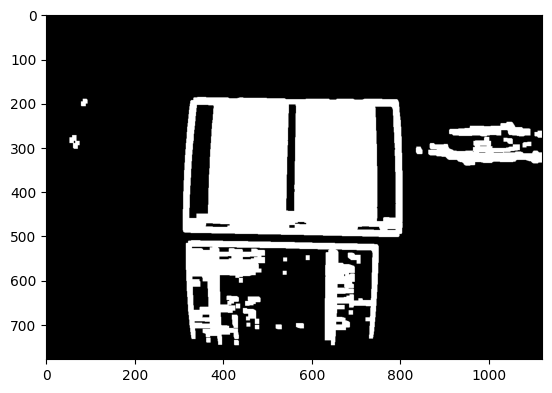

In [158]:
# Construct closing SE and apply it to the thresholded image
def dilate(image, ksize, iteration):
    se = cv2.getStructuringElement(cv2.MORPH_RECT, ksize)
    closed = cv2.morphologyEx(image, cv2.MORPH_CLOSE, se)

    # perform a series of erosions and dilations
    # closed = cv2.erode(closed, None, iterations=iteration)
    closed = cv2.dilate(closed, None, iterations=iteration)
    return closed


morphed = dilate(thresh, [21, 7], 4)
plt.imshow(morphed, cmap='gray')

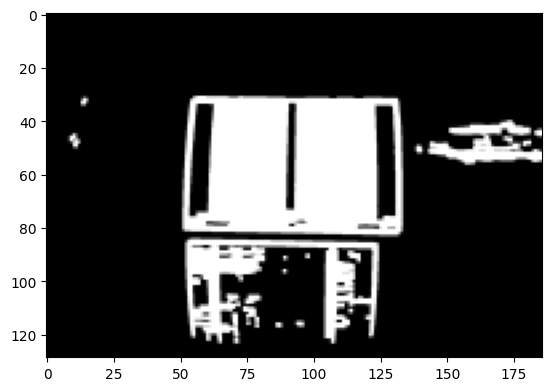

In [159]:
def resize(image, size):
    return cv2.resize(image, size, interpolation=cv2.INTER_AREA)
# Shrink
new_width = int(morphed.shape[1] / 6)
new_height = int(morphed.shape[0] / 6)

shrunk = resize(morphed, [new_width, new_height])
plt.imshow(shrunk, cmap='gray')
# Enlarge

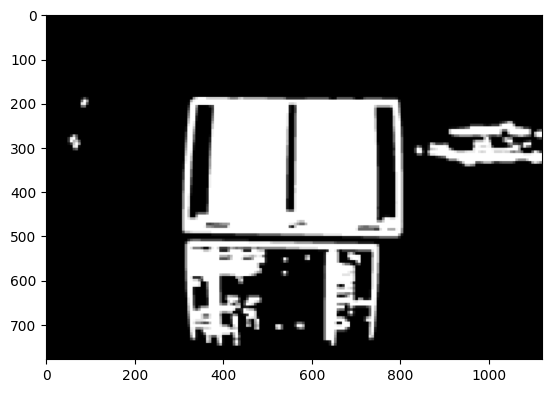

In [160]:
enlarged = resize(shrunk, (morphed.shape[1], morphed.shape[0]))
plt.imshow(enlarged, cmap='gray')

In [161]:
# find the contours in the thresholded image, then sort the contours by their area, keeping only the largest one
(cnts, _) = cv2.findContours(enlarged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
c = sorted(cnts, key=cv2.contourArea, reverse=True)[0]
# compute the rotated bounding box of the largest contour
rect = cv2.minAreaRect(c)
box = np.intp(cv2.boxPoints(rect))
# draw a bounding box arounded the detected barcode and display the image
cv2.drawContours(img, [box], -1, (0, 255, 0), 3)

array([[[ 37,  37,  30],
        [ 36,  36,  30],
        [ 37,  36,  31],
        ...,
        [ 24,  19,  20],
        [ 23,  19,  19],
        [ 22,  19,  19]],

       [[ 38,  37,  30],
        [ 37,  36,  30],
        [ 37,  37,  31],
        ...,
        [ 24,  19,  20],
        [ 22,  19,  19],
        [ 22,  19,  19]],

       [[ 38,  37,  31],
        [ 37,  37,  31],
        [ 37,  37,  31],
        ...,
        [ 24,  20,  20],
        [ 22,  19,  19],
        [ 22,  19,  19]],

       ...,

       [[106,  71,  67],
        [105,  71,  67],
        [106,  71,  69],
        ...,
        [ 63,   9,  15],
        [ 62,   9,  14],
        [ 62,   8,  14]],

       [[105,  72,  67],
        [103,  70,  65],
        [106,  73,  69],
        ...,
        [ 61,   9,  16],
        [ 60,   8,  15],
        [ 60,   7,  14]],

       [[104,  73,  68],
        [103,  71,  66],
        [107,  74,  69],
        ...,
        [ 60,  10,  17],
        [ 59,  10,  16],
        [ 59,   9,  15]]

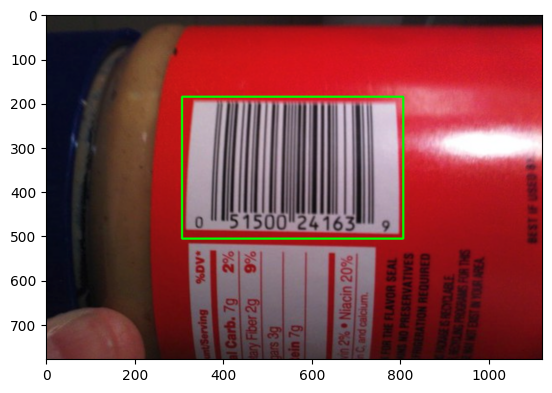

In [162]:
plt.imshow(img)

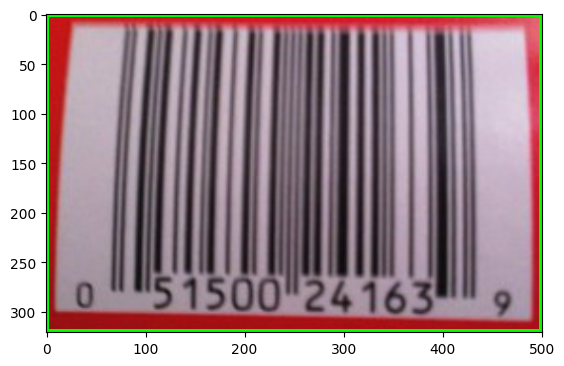

In [163]:
# plt.imshow(box)
[X, Y, W, H] = cv2.boundingRect(box)
cropped = img[Y:Y + H, X:X + W]
plt.imshow(cropped)